In [25]:
import numpy as np
import healpy as hp
import skyproj
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import astropy.coordinates
from astropy import units as u
from astropy import table as apt
from scipy import stats
import galstreams #contains stream data
%matplotlib inline

## define some functions

In [2]:
def change_coord(m, coord):   
    """ Change coordinates of a HEALPIX mapc

    Parameters
    ----------
    m : map or array of maps
      map(s) to be rotated
    coord : sequence of two character
      First character is the coordinate system of m, second character
      is the coordinate system of the output map. As in HEALPIX, allowed
      coordinate systems are 'G' (galactic), 'E' (ecliptic) or 'C' (equatorial)

    Example
    -------
    The following rotate m from galactic to equatorial coordinates.
    Notice that m can contain both temperature and polarization.
    >>>> change_coord(m, ['G', 'C'])
    """
    # Basic HEALPix parameters
    npix = m.shape[-1]
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))

    # Select the coordinate transformation
    rot = hp.Rotator(coord=reversed(coord))

    # Convert the coordinates
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)

    return m[..., new_pix]

 # from https://stackoverflow.com/questions/44443498/how-to-convert-and-save-healpy-map-to-different-coordinate-system

In [60]:
def plot_streams(sp, mws=None, dist=False, streamlist=None, annotate=False):
    """ Plots streams from the galstreams package.

    Parameters
    ----------
    sp : skyproj object
      map on which to plot the streams
    mws : galstreams MWStreams instance of the stream catalog
      catalog of streams to plot (see galstreams documentation)
      if not provided, loads it (pre-loading speeds up loops) 
      and deletes it afterward (saves memory)
    dist : boolean
      whether to plot the streams colored and labeled individually (False) 
      or using a common color scale proportional to their heliocentric distance (True)
    streamlist : list of strings
      which streams to plot from the catalog. if None, plots all of them
    annotate : boolean
      whether to label each stream with its number in the catalog
      (for easier identification)
      
    Returns
    -------
    cbh : figure handle containing information needed to produce a colorbar 
    
    Example
    -------
    Plot all the streams; load the stream catalog in situ 
    >>>> plot_streams(sp)
    Plot a list of streams from a pre-loaded catalog, colored by distance and labeled
    >>>> # load the catalog:
    >>>> mws = galstreams.MWStreams(verbose=False, implement_Off=False, print_topcat_friendly_files=False)
    >>>> # select streams near the south pole
    >>>> s_pole = mws.get_track_names_in_sky_window([0,359]*u.deg, [-90,-30]*u.deg, frame=astropy.coordinates.Galactic)
    >>>> # plot in a pre-defined skyproj
    >>>> plot_streams(sp, mws, distance=True, streamlist=s_pole, annotate=True)
    """
    if mws is None:
        mws = galstreams.MWStreams(verbose=False, implement_Off=False, print_topcat_friendly_files=False)
        cleanup = True
    else: cleanup = False
    if streamlist is None: streamlist = mws.keys()
    for st in streamlist:
        if dist:
            cmap = plt.get_cmap('magma')
            norm = matplotlib.colors.LogNorm(vmin=5.0,vmax=60.)
      #Plot the tracks of streams with distances in color, otherwise gray
            if mws.summary.has_D[st]==1:
                cbh = sp.scatter(mws[st].track.galactic.l.wrap_at(180*u.deg).value, 
                 mws[st].track.galactic.b.value, c=mws[st].track.distance,
                                 alpha=0.75, s=10, marker='.', cmap=cmap, norm=norm,
                 label="{ID:.0f}={Name}".format(ID=mws[st].ID,Name=mws[st].stream_name))
            else: #streams whose distances have not been measured are plotted in gray
                cbh = sp.scatter(mws[st].track.galactic.l.wrap_at(180*u.deg).value, 
                 mws[st].track.galactic.b.value, c='gray', alpha=0.75, s=10, marker='.', 
             label="{ID:.0f}={Name}".format(ID=mws[st].ID,Name=mws[st].stream_name))
        else: #plot streams in alternating colors
            cbh = sp.scatter(mws[st].track.galactic.l.wrap_at(180*u.deg).value, 
                 mws[st].track.galactic.b.value, alpha=0.75, s=5, marker='.', 
             label="{ID:.0f}={Name}".format(ID=mws[st].ID,Name=mws[st].stream_name))
        if annotate:
            xo = mws[st].end_points.galactic.l.wrap_at(180*u.deg)[0].value
            yo = mws[st].end_points.galactic.b[0].value
            ext = sp.get_extent()
            lmin,lmax,bmin,bmax = min(ext[:2]), max(ext[:2]), min(ext[2:]), max(ext[2:])
            if xo<lmin or xo>lmax or yo<bmin or yo>bmax:
                xo = mws[st].end_points.galactic.l.wrap_at(180*u.deg)[1].value
                yo = mws[st].end_points.galactic.b[1].value
            sp.ax.text(xo,yo,mws[st].ID)
    if cleanup:
        del(mws)
    return cbh

## make maps of Gaia stars and HLWAS footprint

In [24]:
# read in healpix Gaia map
filename = 'gaia_stellar_density_map_G_21_gal_nside_128_v0.fits'
gaiamap = hp.read_map(filename)
#gaiamap = change_coord(gaiamap, ['G', 'C'])
gaiamap -= np.min(gaiamap)
scale = np.std(gaiamap)*0.2
print(scale)
scaled_gmap = np.asinh(gaiamap/scale)
stats.describe(scaled_gmap)

3871.5254


DescribeResult(nobs=196608, minmax=(np.float32(0.0), np.float32(4.782536)), mean=np.float32(0.8090007), variance=np.float64(0.9290710854967015), skewness=np.float64(1.5884634256362915), kurtosis=np.float32(1.9741592))

In [4]:
# Read maps with the "tiles" covered -- these are built from APT's outputs
HLWAS_wide = hp.read_map('HLWAS_WIDE_0328_APT994_1024.fits.gz')
HLWAS_medium = hp.read_map('HLWAS_MEDIUM_0328_APT994_1024.fits.gz')
GPS = hp.read_map('GPS_ALL_0328_1024.fits.gz')
maps = [HLWAS_wide, HLWAS_medium, GPS]

In [5]:
# Combine all maps -- HLWAS Wide = 1, HLWAS medium = 2, GPS = 3
debug = False
combined_map = np.zeros_like(HLWAS_wide)
for i, m in enumerate(maps):
    m[m==hp.UNSEEN] = 0.
    combined_map[m!=0] = (i+1)*1.0
    if debug:
        hp.mollview(combined_map, coord=['C','G'])

In [6]:
combined_map[combined_map <=0] = hp.UNSEEN # Fill back with UNSEEN
combined_map = change_coord(combined_map,['C','G'])

In [7]:
# Create a custom colorbar for the 3 maps
from matplotlib.colors import ListedColormap
import matplotlib
# Let's also design our color mapping: 1s should be plotted in blue, 2s in red, etc...
col_dict = {1: "palegreen", # "lightskyblue",
            2: "limegreen", # "dodgerblue",
            3: "firebrick"}

# We create a colormar from our list of colors
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

# Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or using another dict maybe could help.
labels = np.array(["HLWAS WIDE", "HLWAS MEDIUM", "GPS"])
len_lab = len(labels)

## read stream catalog to get GD-1 track

In [44]:
mws = galstreams.MWStreams(verbose=False, implement_Off=False, print_topcat_friendly_files=False)

Initializing galstreams library from master_log... 


## read GD-1 data

In [28]:
gd1_stars = apt.Table.read('gd1_tbl_with_memb_prob.mrt',format='ascii.mrt')

In [62]:
members = gd1_stars['memb_prob']>0.5

In [63]:
gd1_coords = astropy.coordinates.SkyCoord(ra=gd1_stars['ra'][members],dec=gd1_stars['dec'][members])

In [64]:
gd1_weights = gd1_stars['memb_prob'][members].value

## make plot

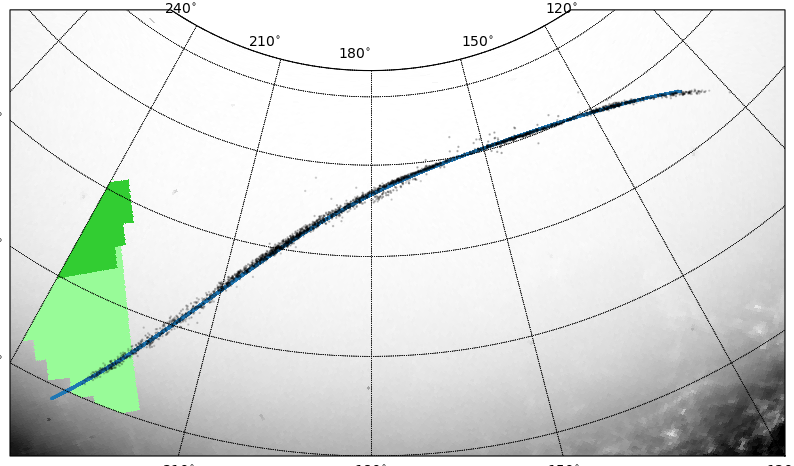

In [85]:
lon_r = (110,240)
lat_r = (15,90)


fig, ax = plt.subplots(figsize=(10,10))
sp = skyproj.AlbersSkyproj(ax=ax, galactic=True, lon_0 = 180.,lat_0=45.,extent=[110,240,15,90])

alph = 1.0

sp.draw_hpxmap(scaled_gmap,cmap='gray_r',vmin=0.5,vmax=5.0,lon_range=lon_r,lat_range=lat_r)

im, _, _, _ = sp.draw_hpxmap(combined_map,alpha=alph, vmin=1, vmax=3, cmap=cm, zoom=False,lon_range=lon_r,lat_range=lat_r)
plot_streams(sp,mws,streamlist=['GD-1-I21'])
sp.scatter(gd1_coords.galactic.l, gd1_coords.galactic.b,c='k',s=0.5,alpha=0.3*gd1_weights)
fig.savefig('../figures/gd1_closeup.png',dpi=200)

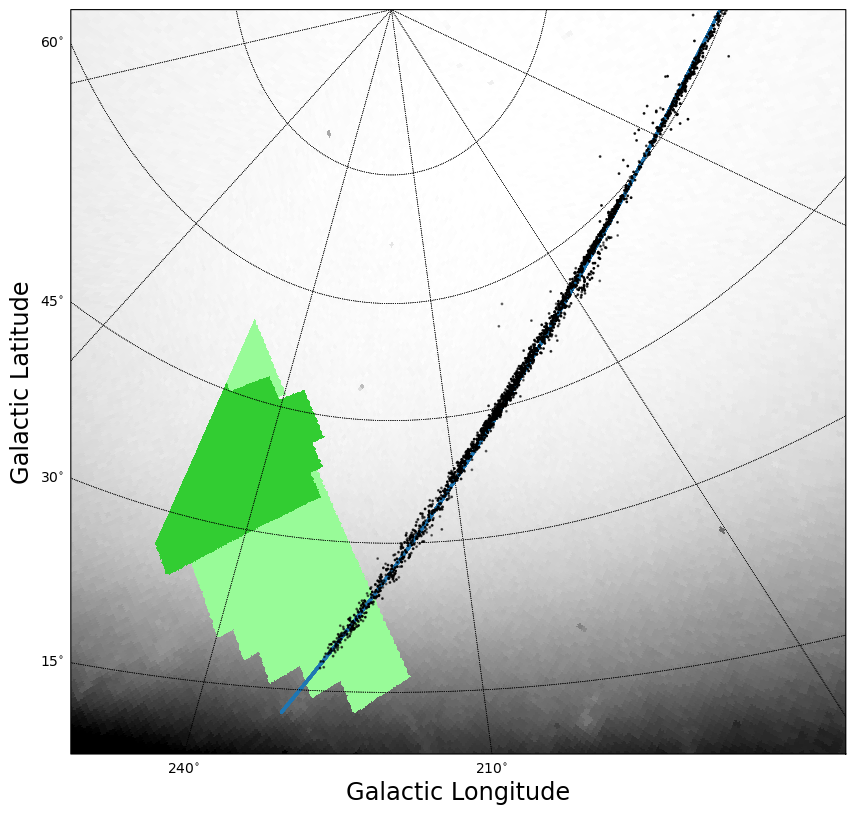

In [66]:
lon_r = (180,250)
lat_r = (10,90)


fig, ax = plt.subplots(figsize=(10,10))
sp = skyproj.GnomonicSkyproj(ax=ax, lon_0=220.0, lat_0=50.0, galactic=True, extent=[180,250,10,50])

alph = 1.0

sp.draw_hpxmap(scaled_gmap,cmap='gray_r',vmin=0.5,vmax=5.0,lon_range=lon_r, lat_range=lat_r)

im, _, _, _ = sp.draw_hpxmap(combined_map, lon_range=lon_r, lat_range=lat_r, alpha=alph, vmin=1, vmax=3, cmap=cm, zoom=False)
plot_streams(sp,mws,streamlist=['GD-1-I21'])
sp.scatter(gd1_coords.galactic.l, gd1_coords.galactic.b,c='k',s=1,alpha=gd1_weights)